(acoustics-scattering_interpretation)=
## Interpreting echoes

(acoustics-scattering_echogram_old)=
### Echograms

We have discussed quite a bit about how different things scatter sound, and how we can use these understandings to interpret echoes. But how do we visualize echoes in a way that the echoes look like? Since the delay it takes for an echo from a certain object to be received by a transducer depends on the distance between the transducer and the object (the "range"), we typically align the echoes—each one a time series of its own—by the time of transmission (the "ping")

<!-- , like below: -->

<!-- ADD FIGURE OF ECHO TIME SERIES IN WATERFALL PLOT -->

This is an interesting plot, because both the vertical and horizontal axis are in the unit of time: the vertical axis are the _global_ time of each ping, and the horizontal axis are the _local_ time measured from the start of each ping. If we know the sound speed, we can easily transform the horizontal axis to be based on distance, based on the understanding that the sound would have traveled a roundtrip from the transducer to the scatterer and back to the transducer, i.e.

$$d = ct/2$$

where $d$ is the distance traveled, $c$ is the sound speed,and $t$ is the time elapsed since transmission.

"Echograms" a essentially color-coded version of the above time series plot, often plotted with the echo magnitude or intensity. Depending whether the sonar is aiming sideways (typical for long-range sonar at lower frequencies) or downward (typical for high-frequency "echosounders"), the echograms may be rotated to align with our intuitive understand of the space we are trying to probe. For example, below is a series of echograms from an horizontal-looking sonar centered around the source-receiver pair in a bird's-eye view, which is very different from the echograms from downward-looking echosounders we will see below.

```{image} ../images/trex_fish_frames.jpeg
:width: 700px
:align: center
```

(acoustics-scattering_inference)=
### Inferring scatterer identity through echo spectrum

From previous sections, we know that echo spectrum is one of the key features we can use to infer the identity or material composition of scatterers. How does this look like in practice? Below we use an echogram from a typical fisheries echosounder as an example.

Many fisheries echosounders use narrowband sound with small bandwidth ("narrowband") spaced out across a large frequency range to try to observe animals from krill to whales that vary dramaticaly in size and anatomical compositions.

In the widget below, you are seeing the same vertical slice of the ocean through give different transducer channels, each centered at the frequency shown on the panel. Based on experience, we know that there are likely both fish and zooplankton in this patch of the ocean. Using what we have learned about how scatterers of different sizes and material properties scatter sound (see [here](acoustics-scattering_discrete_size_materials_widget) for a review), can you guess which part of the echogram is dominated by swimbladder-bearing fish, and which part of the echogram is dominated by zooplankton that are numerous but small?

```{Tip}
:class: tip
Hint: swimbladder has air in it, and the body of many zooplankton animals are made of materials very close to seawater.
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets

In [15]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

In [99]:
a = 0.15
L = a * 12
g = 1.043
h = 1.053
c = 1500

freq = np.arange(100, 30e3, 10)
ka = 2*np.pi*freq / c * a

phi = np.deg2rad(0)  # incident angle in radians (e.g., backscatter)
fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
TS = 20*np.log10(np.abs(fbs))


<function matplotlib.pyplot.show(close=None, block=None)>

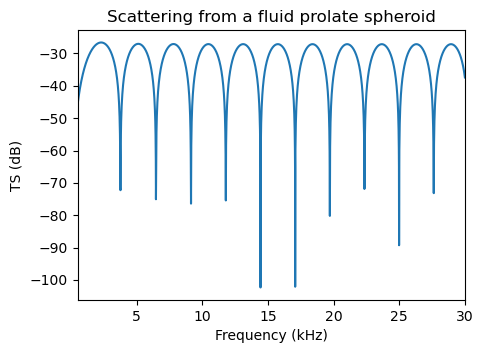

In [100]:
plt.figure(figsize=(5,3.5))
plt.plot(freq/1e3, TS)
plt.xlim(500/1e3, 30e3/1e3)
# plt.ylim(-120, -50)
plt.xlabel("Frequency (kHz)")
plt.ylabel("TS (dB)")
plt.title("Scattering from a fluid prolate spheroid")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

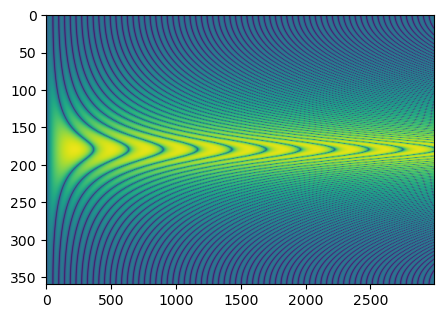

In [101]:
a = 0.15
L = a * 12
g = 1.043
h = 1.053
c = 1500

freq = np.arange(100, 30e3, 10)
ka = 2*np.pi*freq / c * a

phi = np.deg2rad(np.arange(-90, 90, 0.5))  # incident angle in radians (e.g., backscatter)
fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
TS = 20*np.log10(np.abs(fbs))

plt.figure(figsize=(5,3.5))
plt.imshow(TS, aspect="auto", vmax=-25, vmin=-80)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

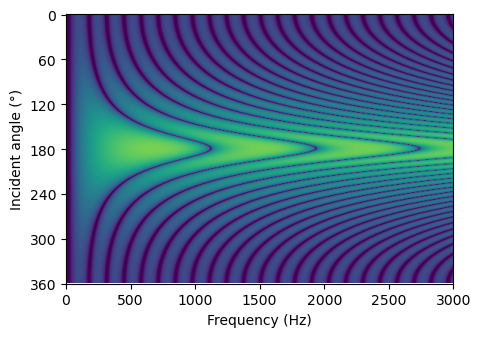

In [111]:
a = 0.05
L = a * 12
g = 1.043
h = 1.053
c = 1500

freq = np.arange(100, 30e3, 10)
ka = 2*np.pi*freq / c * a

phi = np.deg2rad(np.arange(-90, 90, 0.5))  # incident angle in radians (e.g., backscatter)
fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
TS = 20*np.log10(np.abs(fbs))

plt.figure(figsize=(5,3.5))
plt.imshow(TS, aspect="auto", vmax=-25, vmin=-80)
plt.yticks(np.arange(0, 361, 60))
plt.ylabel("Incident angle (°)")
plt.xticks(np.arange(0, 3001,500))
plt.xlabel("Frequency (Hz)")
plt.show

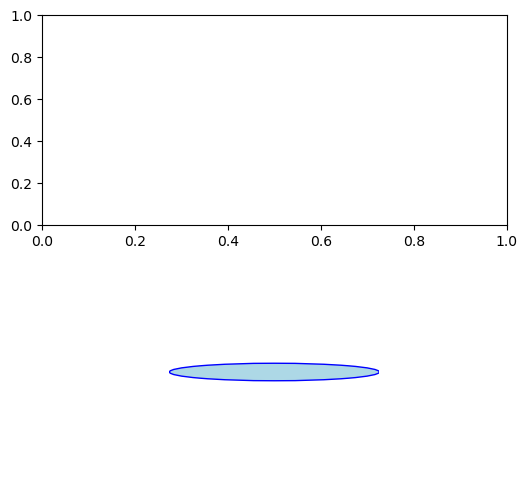

In [135]:
import matplotlib.patches as patches

# Define ellipse parameters
angle_inc = 0
width = a      # width of the ellipse
height = a * 12     # height of the ellipse
angle = 90-angle_inc      # rotation angle in degrees

# Create the ellipse patch
ellipse = patches.Ellipse((0.5, 0.5), width, height, angle=angle, 
                         facecolor='lightblue', edgecolor='blue') # optional: styling

# Plot the ellipse
fig, ax = plt.subplots(2,1, figsize=(6,6))
ax[1].add_patch(ellipse)
ax[1].set_aspect('equal', adjustable='box')
ax[1].axis('off')
ax[1].set_xlim(0.2, 0.8)
ax[1].set_ylim(0.2, 0.8)
# ax[1].set_aspect('equal')
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

import ipywidgets as widgets

from IPython.display import display

In [2]:
mtx = np.load("../resources/x0052_0_wt_20170726_011534_f0009.npy")

a_min = -70
a_max = -50
with np.errstate(divide='ignore', invalid='ignore'):
    mtx_clip = (
        ((np.clip(mtx, a_min=a_min, a_max=a_max) - a_min)
         / (a_max - a_min) * 255).astype(int)
    )

In [3]:
x_box_len = 50
y_box_len = 200

def get_echo_hist(x_idx,y_idx):
    fig, ax = plt.subplots(1,3,figsize=(8, 3), sharey=True)
    fig.subplots_adjust(wspace=0.05)
    for ch, freq in zip(range(3), [18, 38, 120]):
        im = ax[ch].imshow(mtx[ch,:,:].T, aspect="auto", vmin=-80, vmax=-40)#, extent=[0, mtx.shape[1], 379, 0])
        ax[ch].set_title(f"{freq} kHz")
        rect = patches.Rectangle((x_idx, y_idx), x_box_len, y_box_len,
                                linewidth=1, edgecolor="w", facecolor="none")
        ax[ch].add_patch(rect)
        ax[ch].set_xlabel("Ping number")
    ax_pos = ax[ch].get_position()
    cax = fig.add_axes([ax_pos.x0+ax_pos.width+0.015, ax_pos.y0, 0.02, ax_pos.height])  # [left, bottom, width, height]
    plt.colorbar(im, cax=cax)
    cax.set_ylabel("Sv (dB)")
    ax[0].set_ylabel("Bin along range")

    plt.show()

    sample = []
    for ch in range(3):
        sample.append(
            mtx[ch, x_idx+np.arange(x_box_len), :][:, y_idx+np.arange(y_box_len)].reshape(-1,1)
        )

    fig = plt.figure(figsize=(6, 2.7), layout='constrained')
    for ch, freq, color in zip(range(3), [18, 38, 120], ["b", "g", "r"]):
        plt.hist(sample[ch], density=True,
                 bins=np.arange(-100, -39, 1), alpha=0.3, facecolor=color,
                 label=f"{freq} kHz")
    plt.xlim(-100, -40)
    plt.legend(bbox_to_anchor=(1.3, 0.8), loc="upper right")
    plt.xlabel("Sv (dB)")
    plt.ylabel("Distribution")
    plt.show()

    plt.figure(figsize=(5.5, 3.5))
    plt.imshow(np.moveaxis(mtx_clip, (0,1,2), (2,1,0))[:, :, ::-1],
               aspect="auto")#, extent=[0, mtx.shape[1], 379, 0])
    rect = patches.Rectangle((x_idx, y_idx), x_box_len, y_box_len,
                            linewidth=1, edgecolor="w", facecolor="none")
    plt.gca().add_patch(rect)
    plt.xlabel("Ping number")
    plt.ylabel("Bin along range")
    plt.title("Tricolor representation")
    plt.show()
    
x_slider = widgets.IntSlider(
    value=250,
    min=0,
    max=390,
    step=1,
    description="x index",
    continuous_update=False,
    style={'description_width': 'initial'} 
)

y_slider = widgets.IntSlider(
    value=1250,
    min=0,
    max=1801,
    step=1,
    description="y index",
    continuous_update=False,
    style={'description_width': 'initial'} 
)

widgets.interactive(get_echo_hist, x_idx=x_slider, y_idx=y_slider)

interactive(children=(IntSlider(value=250, continuous_update=False, description='x index', max=390, style=Slid…

In the last panel above, we mapped the echo strengths at the three frequencies into the RGB bands to assemble the "tricolor" representation, which conveniently summarizes the spectral information and very useful for initial interpretation of echograms.

We also would like to share this one example below that we found really beautiful!


```{image} ../images/tricolor_long.png
:width: 750px
:align: center
```